<a href="https://colab.research.google.com/github/sujitkoley9/Sequence-to-sequence-model/blob/master/Machine_Translator_(English_to_Hindi).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<b>Important Link:</b>
1. https://www.youtube.com/watch?v=QuELiw8tbx8&feature=youtu.be&list=PL3FW7Lu3i5Jsnh1rnUwq_TcylNr7EkRe6&t=1190
2. https://medium.com/analytics-vidhya/machine-translation-encoder-decoder-model-7e4867377161


In [0]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

In [0]:
#!pip install --upgrade tensorflow

In [0]:
import h5py

In [0]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense
import numpy as np
import io


# Load the Data

In [6]:
# Assign the data path.
data_path = "hin.txt"

# Read in the data.
lines = io.open(data_path, encoding = "utf-8").read().split("\n")
lines  = lines[:-1]
print(lines[1])
# Split the data into input and target sequences.
lines = [line.split("\t") for line in lines]
print(lines[0])
# We define the starting signal to be "\t" and the
# ending signal to be "\n". These signals tell the
# model that when it sees "\t" it should start
# producing its translation and produce "\n" when
# it wants to end its translation. Let us add
# "\t" to the start and "\n" to the end 
# of all input and output sentences.
lines = [("\t" + line[0] + "\n", "\t" + line[1] + "\n") for
            line in lines]

Jump.	उछलो.
['Help!', 'बचाओ!']


In [7]:
print (lines[0][1])

	बचाओ!



# Figure out the Best Lengths of Sentences

## Compute Sentence Lengths

In [0]:
# Compute the input and output lengths.
input_lengths = np.array([len(line[0]) for line in lines])
output_lengths = np.array([len(line[1]) for line in lines])

In [13]:
print(len(input_lengths))

2869


[75, 80, 0, 120]

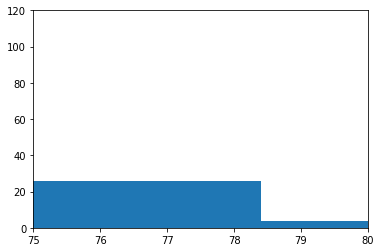

In [14]:
plt.hist(input_lengths)
plt.axis([75,80, 0 , 120])

[85, 89, 0, 20]

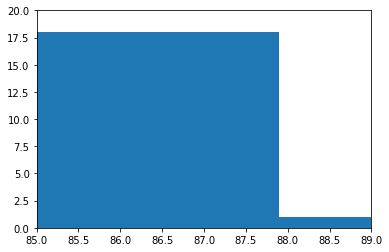

In [15]:
plt.hist(output_lengths)
plt.axis([85,89,0,20])

In [0]:
english = 78
hindi = 87

In [0]:
line1 = []
for i in range(len(input_lengths)):
    if(input_lengths[i]<75 and output_lengths[i]<85):
        line1 = line1 + [lines[i]]
        

In [18]:
print(len(line1))

2856


## Input Length

Plotted the histogram of the length of the input sentences and choose the length that makes the most sense. 

The reason we don't want sentences that are too long is because the computation becomes trickier for longer sentences and the performance also degrades. However we also want as many sentences in our dataset as possible.

Thus it is important to choose the right length and discard sentences longer than this.

## Output Length

Repeat the same for the lengths of the output sentences

In [0]:
batch_size = 64  # Batch size for training.
epochs = 100  # Number of epochs to train for.
latent_dim = 256  # Latent dimensionality of the encoding space.
num_samples = 2869  # Number of samples to train on.

In [0]:
input_texts = [(line[0]) for line in line1]
target_texts = [(line[1]) for line in line1]

In [0]:
input_characters = set()
target_characters = set()

In [0]:
for input_text in input_texts:
    for char in input_text:
        if char not in input_characters:
            input_characters.add(char)

for target_text in target_texts:
    for char in target_text:
        if char not in target_characters:
            target_characters.add(char)

In [25]:
print(len(input_characters))
print(len(target_characters))

72
92


In [0]:
input_characters = sorted(list(input_characters))
target_characters = sorted(list(target_characters))
num_encoder_tokens = len(input_characters)
num_decoder_tokens = len(target_characters)
max_encoder_seq_length = max([len(txt) for txt in input_texts])
max_decoder_seq_length = max([len(txt) for txt in target_texts])

In [27]:
print('Number of samples:', len(input_texts))
print('Number of unique input tokens:', num_encoder_tokens)
print('Number of unique output tokens:', num_decoder_tokens)
print('Max sequence length for inputs:', max_encoder_seq_length)
print('Max sequence length for outputs:', max_decoder_seq_length)

Number of samples: 2856
Number of unique input tokens: 72
Number of unique output tokens: 92
Max sequence length for inputs: 74
Max sequence length for outputs: 82


In [0]:
input_token_index = dict(
    [(char, i) for i, char in enumerate(input_characters)])
target_token_index = dict(
    [(char, i) for i, char in enumerate(target_characters)])

In [0]:
encoder_input_data = np.zeros(
    (len(input_texts), max_encoder_seq_length, num_encoder_tokens),
    dtype='float32')
decoder_input_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens),
    dtype='float32')
decoder_target_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens),
    dtype='float32')

In [0]:
for i, (input_text, target_text) in enumerate(zip(input_texts, target_texts)):
    for t, char in enumerate(input_text):
        encoder_input_data[i, t, input_token_index[char]] = 1.
    for t, char in enumerate(target_text):
        decoder_input_data[i, t, target_token_index[char]] = 1.
        if t > 0:
            
            decoder_target_data[i, t - 1, target_token_index[char]] = 1.

In [0]:

encoder_inputs = Input(shape=(None, num_encoder_tokens))
encoder = LSTM(latent_dim, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_inputs)

encoder_states = [state_h, state_c]

decoder_inputs = Input(shape=(None, num_decoder_tokens))

decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs,
                                     initial_state=encoder_states)
decoder_dense = Dense(num_decoder_tokens, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

In [0]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy')


In [0]:
epochs = 100

In [34]:
model.fit([encoder_input_data, decoder_input_data], decoder_target_data,batch_size=batch_size,epochs=epochs,validation_split=0.2)

Train on 2284 samples, validate on 572 samples
Epoch 1/100
2284/2284 [==============================] - 36s 16ms/sample - loss: 1.2195 - val_loss: 1.9141
Epoch 2/100
2284/2284 [==============================] - 31s 14ms/sample - loss: 1.1349 - val_loss: 1.8452
Epoch 3/100
2284/2284 [==============================] - 31s 14ms/sample - loss: 1.1173 - val_loss: 1.7307
Epoch 4/100
2284/2284 [==============================] - 31s 14ms/sample - loss: 1.0027 - val_loss: 1.6143
Epoch 5/100
2284/2284 [==============================] - 31s 13ms/sample - loss: 0.9288 - val_loss: 1.5272
Epoch 6/100
2284/2284 [==============================] - 30s 13ms/sample - loss: 0.8763 - val_loss: 1.4800
Epoch 7/100
2284/2284 [==============================] - 31s 13ms/sample - loss: 0.8327 - val_loss: 1.4047
Epoch 8/100
2284/2284 [==============================] - 29s 13ms/sample - loss: 0.7981 - val_loss: 1.3716
Epoch 9/100
2284/2284 [==============================] - 29s 13ms/sample - loss: 0.7725 - val_los

In [0]:
model.save('s2s.h5')


In [0]:
encoder_model = Model(encoder_inputs, encoder_states)

decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
decoder_outputs, state_h, state_c = decoder_lstm(
    decoder_inputs, initial_state=decoder_states_inputs)
decoder_states = [state_h, state_c]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs] + decoder_states)

reverse_input_char_index = dict(
    (i, char) for char, i in input_token_index.items())
reverse_target_char_index = dict(
    (i, char) for char, i in target_token_index.items())

In [0]:
def decode_sequence(input_seq):
    states_value = encoder_model.predict(input_seq)

    target_seq = np.zeros((1, 1, num_decoder_tokens))
    target_seq[0, 0, target_token_index['\t']] = 1.

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict(
            [target_seq] + states_value)

        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = reverse_target_char_index[sampled_token_index]
        decoded_sentence += sampled_char

        if (sampled_char == '\n' or
           len(decoded_sentence) > max_decoder_seq_length):
            stop_condition = True

        target_seq = np.zeros((1, 1, num_decoder_tokens))
        target_seq[0, 0, sampled_token_index] = 1.

        states_value = [h, c]

    return decoded_sentence


In [38]:
for seq_index in range(100):
    
    input_seq = encoder_input_data[seq_index: seq_index + 1]
    decoded_sentence = decode_sequence(input_seq)
    print('-')
    print(input_texts[seq_index])
    print(decoded_sentence)

-
	Help!

मुझे देखने दो।

-
	Jump.

किसको पता है?

-
	Jump.

किसको पता है?

-
	Jump.

किसको पता है?

-
	Hello!

मुझे देखने दो।

-
	Hello!

मुझे देखने दो।

-
	Cheers!

यह मेरा बत्ता है।

-
	Cheers!

यह मेरा बत्ता है।

-
	Got it?

यह किताब कहीँ है?

-
	I'm OK.

मैं अपनी नादी से हफ़्ते में दो बार मिलने जाता हूँ।

-
	Awesome!

मुझे देखने दो।

-
	Come in.

यह मेरा बत्ता है।

-
	Get out!

यह मेरा पति लहाती है।

-
	Go away!

यह मेरा पति लाही है।

-
	Goodbye!

यह मेरा बत्ता है।

-
	Perfect!

मुझे देखने दो।

-
	Perfect!

मुझे देखने दो।

-
	Welcome.

यह मेरा बत्ता है।

-
	Welcome.

यह मेरा बत्ता है।

-
	Have fun.

मुझे देखने दो।

-
	Have fun.

मुझे देखने दो।

-
	Have fun.

मुझे देखने दो।

-
	I forgot.

मैं अपनी नादी से हफ़्ते में दो बार मिलने जाता हूँ।

-
	I forgot.

मैं अपनी नादी से हफ़्ते में दो बार मिलने जाता हूँ।

-
	I'll pay.

मैं अपनी कामा का फूँढ़ रहाँ हो।

-
	I'm fine.

मैं अपनी नादी से हफ़्ते में दो बार मिलने जाता हूँ।

-
	I'm full.

मैं अपनी नादी से हफ़्ते में दो बार मिलने जाता हूँ।

-